In [66]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, \
    median_absolute_error, mean_squared_error, mean_squared_log_error, classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Описание задачи

Предсказание числа пассажиров на ближайшее время, которые будут пользоваться метро.

Загрузим датасет и ознакомимся с ним. Исходный датасет взят отсюда: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [2]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', sep = ',', decimal = '.', encoding = 'utf-8')
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## Описание столбцов
Нас интересуют следующие данные.
- traffic_volume - Объем пассажиропотока. Целевая переменная.
- date_time - Дата и время снятия показаний.
- holiday - Является день праздником.
- temp - Температура воздуха на улице.

Оставим только нужные столбцы в датасете.

In [3]:
data = data[['holiday', 'temp', 'date_time', 'traffic_volume']]

## EDA

Перед началом моделирования проведем первичный анализ данных.

Посмотрим на типы данных в нашем датасете. И проверим есть ли пропуски в данных.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  object 
 1   temp            48204 non-null  float64
 2   date_time       48204 non-null  object 
 3   traffic_volume  48204 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [5]:
data.isnull().sum()

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64

Как мы видим, пропусков в данных нет.
Проверим наш датасет на наличие дублирующих строк. Для этого сформируем признак.

In [6]:
data['duplicated'] = data[data.columns].duplicated(keep=False)

In [7]:
data[data['duplicated'] == True].head(10)

,holiday,temp,date_time,traffic_volume,duplicated
178,None,281.25,2012-10-10 07:00:00,6793,True
179,None,281.25,2012-10-10 07:00:00,6793,True
180,None,280.10,2012-10-10 08:00:00,6283,True
181,None,280.10,2012-10-10 08:00:00,6283,True
182,None,279.61,2012-10-10 09:00:00,5680,True
183,None,279.61,2012-10-10 09:00:00,5680,True
269,None,282.43,2012-10-14 09:00:00,2685,True
270,None,282.43,2012-10-14 09:00:00,2685,True
271,None,282.43,2012-10-14 09:00:00,2685,True
272,None,282.33,2012-10-14 10:00:00,3370,True


В нашем датасете есть дублирующие строки. Уберем дубли.

In [8]:
data = data.drop_duplicates(subset=data.columns)

In [9]:
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d')
data.head()

,holiday,temp,date_time,traffic_volume,duplicated
0,None,288.28,2012-10-02 09:00:00,5545,False
1,None,289.36,2012-10-02 10:00:00,4516,False
2,None,289.58,2012-10-02 11:00:00,4767,False
3,None,290.13,2012-10-02 12:00:00,5026,False
4,None,291.14,2012-10-02 13:00:00,4918,False


Преобразуем переменную holiday в числовую переменную, где 0 будет означать обычный день, а 1 - праздничный.

In [10]:
data['holiday'] = np.where(data['holiday'] == 'None', 0, 1)

Посмотрим на каком периоде у нас даны данные

In [11]:
date_range = str(min(data['date_time'])) + ' to ' +str(max(data['date_time']))
date_range

'2012-10-02 09:00:00 to 2018-09-30 23:00:00'

Проверим, все ли данные отстают друг от друга на 1 час.

In [12]:
data['check_time'] = data['date_time'].diff()
data['check_time'].value_counts()

0 days 01:00:00      37986
0 days 02:00:00       2192
0 days 03:00:00        201
0 days 00:00:00         78
0 days 04:00:00         59
0 days 05:00:00         33
0 days 06:00:00         17
0 days 08:00:00         13
0 days 10:00:00         13
0 days 09:00:00         12
0 days 07:00:00         10
0 days 11:00:00          4
1 days 00:00:00          4
0 days 22:00:00          4
0 days 13:00:00          3
0 days 14:00:00          3
1 days 06:00:00          2
0 days 15:00:00          2
0 days 12:00:00          2
0 days 21:00:00          2
2 days 17:00:00          1
10 days 03:00:00         1
1 days 01:00:00          1
0 days 18:00:00          1
1 days 09:00:00          1
4 days 21:00:00          1
1 days 23:00:00          1
307 days 19:00:00        1
3 days 21:00:00          1
0 days 17:00:00          1
4 days 22:00:00          1
1 days 10:00:00          1
Name: check_time, dtype: int64

Как мы видим, в данных не все данные отстают друг друга на 1 час. Сформируем новые данные, в которых все данные будут отставать друг от друга на 1 час.

In [19]:
data_trf = pd.DataFrame(pd.date_range(start ='2012-10-02 09:00:00', 
             end ='2018-09-30 23:00:00', freq ='1H'))
data_trf = data_trf.rename({0 : 'date_time'}, axis=1)
data_trf.head()

,date_time
0,2012-10-02 09:00:00
1,2012-10-02 10:00:00
2,2012-10-02 11:00:00
3,2012-10-02 12:00:00
4,2012-10-02 13:00:00


Подсоединим числовые данные из исходного датафрейма.

In [20]:
data_trf = data_trf.merge(data[['date_time', 'temp', 'traffic_volume']], how='left', on='date_time')

Заполним пропуски для числовых данных с помощью интерполяции

In [21]:
data_trf = data_trf.interpolate()

In [22]:
data_trf.head()

,date_time,temp,traffic_volume
0,2012-10-02 09:00:00,288.28,5545.0
1,2012-10-02 10:00:00,289.36,4516.0
2,2012-10-02 11:00:00,289.58,4767.0
3,2012-10-02 12:00:00,290.13,5026.0
4,2012-10-02 13:00:00,291.14,4918.0


Теперь подсоединим значения переменной holiday из исходного датафрейма по датам. Создадим поле, в котором будет отсутствовать время.

In [23]:
data['date'] = data['date_time'].dt.date
data_trf['date'] = data_trf['date_time'].dt.date

Создадим датасет с уникальными датами для подцепки.

In [24]:
data_hday = data[['date', 'holiday']]
data_hday = data_hday.drop_duplicates(subset='date', keep='first')
data_hday.head()

,date,holiday
0,2012-10-02,0
15,2012-10-03,0
35,2012-10-04,0
59,2012-10-05,0
81,2012-10-06,0


In [25]:
data_trf = data_trf.merge(data_hday, how='left')
data_trf.head()

,date_time,temp,traffic_volume,date,holiday
0,2012-10-02 09:00:00,288.28,5545.0,2012-10-02,0.0
1,2012-10-02 10:00:00,289.36,4516.0,2012-10-02,0.0
2,2012-10-02 11:00:00,289.58,4767.0,2012-10-02,0.0
3,2012-10-02 12:00:00,290.13,5026.0,2012-10-02,0.0
4,2012-10-02 13:00:00,291.14,4918.0,2012-10-02,0.0


Удалим лишние поле date

In [26]:
data_trf = data_trf.drop('date', axis=1)

Для дальнейшего анализа в качестве индекса будем использовать дату и время.

In [27]:
data_trf = data_trf.set_index('date_time')
data_trf.head()

,temp,traffic_volume,holiday
date_time,,,
2012-10-02 09:00:00,288.28,5545.0,0.0
2012-10-02 10:00:00,289.36,4516.0,0.0
2012-10-02 11:00:00,289.58,4767.0,0.0
2012-10-02 12:00:00,290.13,5026.0,0.0
2012-10-02 13:00:00,291.14,4918.0,0.0


## Разбивка на обучающую и тестовую выборки

Отложим последние две недели в данных для тестовой выборки. Для начала рассчитаем номер и день недели. Также рассчитаем час, он понадобится в дальнейшем.

In [28]:
data_trf['week'] = pd.DatetimeIndex(data_trf.index).week
data_trf['weekday'] = pd.DatetimeIndex(data_trf.index).day_name()
data_trf['hour'] = pd.DatetimeIndex(data_trf.index).hour
data_trf['month'] = pd.DatetimeIndex(data_trf.index).month
data_trf['year'] = pd.DatetimeIndex(data_trf.index).year
data_trf.head()

,temp,traffic_volume,holiday,week,weekday,hour,month,year
date_time,,,,,,,,
2012-10-02 09:00:00,288.28,5545.0,0.0,40,Tuesday,9,10,2012
2012-10-02 10:00:00,289.36,4516.0,0.0,40,Tuesday,10,10,2012
2012-10-02 11:00:00,289.58,4767.0,0.0,40,Tuesday,11,10,2012
2012-10-02 12:00:00,290.13,5026.0,0.0,40,Tuesday,12,10,2012
2012-10-02 13:00:00,291.14,4918.0,0.0,40,Tuesday,13,10,2012


Проверим, является ли последняя дата в нашем датасете окончанием недели. Для этого возьмем из нашего датасета последнюю строку.

In [29]:
data_trf.loc[data_trf.last_valid_index(), 'weekday']

'Sunday'

Как мы видим, последняя дата является воскресеньем. Теперь отложим последние две недели для теста. Запишем небольшую функцию.

In [30]:
def data_train_test_split(df):
    last_week = df.loc[df.last_valid_index(), 'week']
    last_year = df.loc[df.last_valid_index(), 'year']
    
    test_df = df[(df['year'] == last_year) & (df['week'].isin([last_week, last_week - 1]))]
    train_df = df[~((df['year'] == last_year) & (df['week'].isin([last_week, last_week - 1])))]
    
    return train_df, test_df

In [31]:
train_df, test_df = data_train_test_split(data_trf)

In [32]:
train_df.head()

,temp,traffic_volume,holiday,week,weekday,hour,month,year
date_time,,,,,,,,
2012-10-02 09:00:00,288.28,5545.0,0.0,40,Tuesday,9,10,2012
2012-10-02 10:00:00,289.36,4516.0,0.0,40,Tuesday,10,10,2012
2012-10-02 11:00:00,289.58,4767.0,0.0,40,Tuesday,11,10,2012
2012-10-02 12:00:00,290.13,5026.0,0.0,40,Tuesday,12,10,2012
2012-10-02 13:00:00,291.14,4918.0,0.0,40,Tuesday,13,10,2012


In [33]:
test_df.head()

,temp,traffic_volume,holiday,week,weekday,hour,month,year
date_time,,,,,,,,
2018-09-17 00:00:00,296.58,550.0,0.0,38,Monday,0,9,2018
2018-09-17 01:00:00,296.19,280.0,0.0,38,Monday,1,9,2018
2018-09-17 02:00:00,295.82,260.0,0.0,38,Monday,2,9,2018
2018-09-17 03:00:00,295.83,344.0,0.0,38,Monday,3,9,2018
2018-09-17 04:00:00,295.68,880.0,0.0,38,Monday,4,9,2018


Посмотрим на динамику нашего временного ряда на графике.

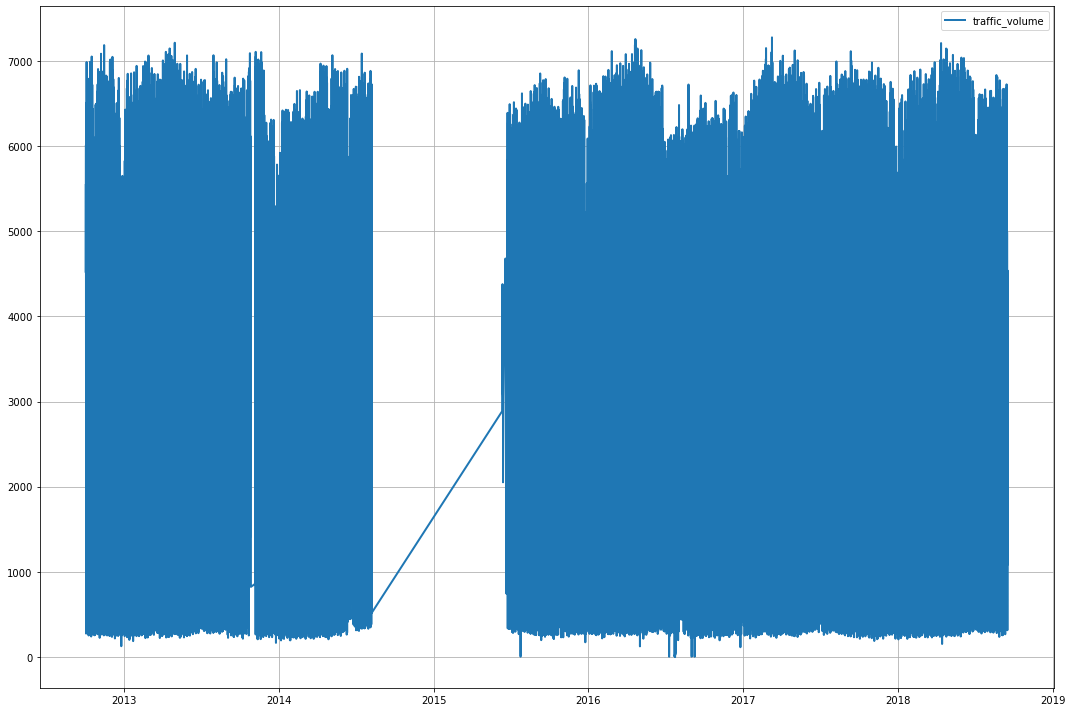

In [34]:
plt.figure(figsize=(15, 10))
plt.plot(train_df.index, train_df[['traffic_volume']].values, label='traffic_volume', linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)

На графике видно, что за 2015 год в исходных данных не было записей о загрузке метро. Интерполяция нам для 2015 года отрисовала ровный линейный тренд.
В связи с этим, уберем все годы, начиная с 2015 года и ранее, чтобы не ухудшать прогноз. Также ограничим данные со 3 квартала 2018 года, чтобы ускорить отработку моделей.

In [35]:
train_df = train_df[(train_df['year'] >= 2018) & (train_df['month'] >= 7)]
train_df.head()

,temp,traffic_volume,holiday,week,weekday,hour,month,year
date_time,,,,,,,,
2018-07-01 00:00:00,297.15,1314.0,0.0,26,Sunday,0,7,2018
2018-07-01 01:00:00,296.65,848.0,0.0,26,Sunday,1,7,2018
2018-07-01 02:00:00,296.15,703.0,0.0,26,Sunday,2,7,2018
2018-07-01 03:00:00,295.62,419.0,0.0,26,Sunday,3,7,2018
2018-07-01 04:00:00,295.36,372.0,0.0,26,Sunday,4,7,2018


Построим еще раз график на наших данных и убедимся, что всё в порядке.

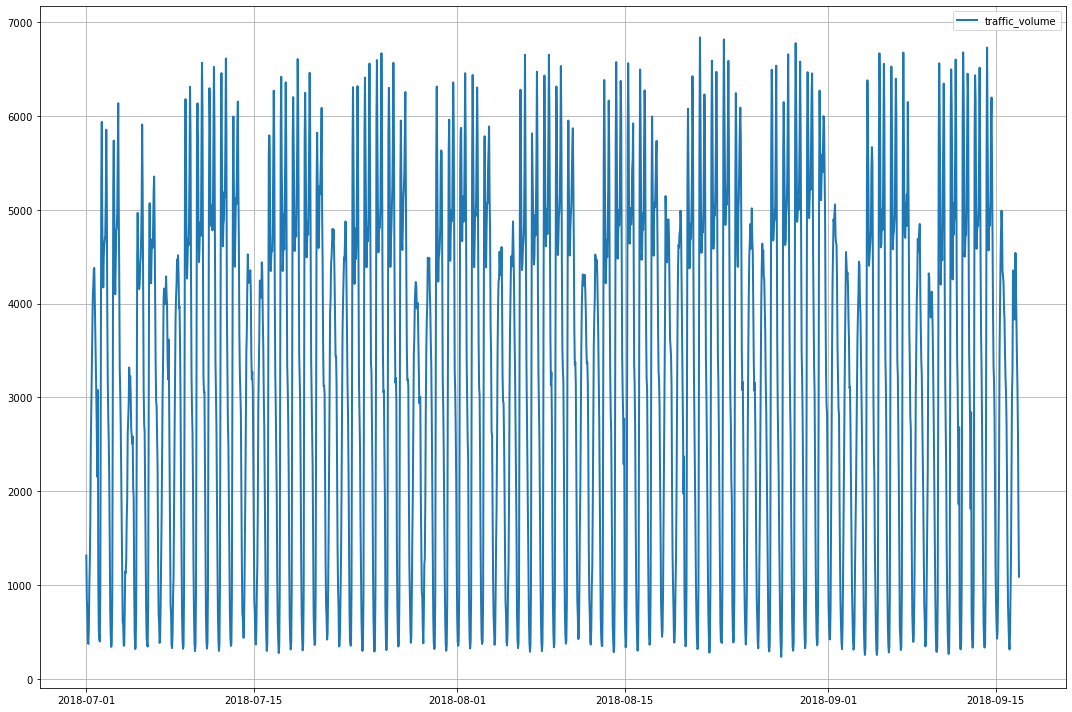

In [36]:
plt.figure(figsize=(15, 10))
plt.plot(train_df.index, train_df[['traffic_volume']].values, label='traffic_volume', linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)

Построим график для тестовой выборки.

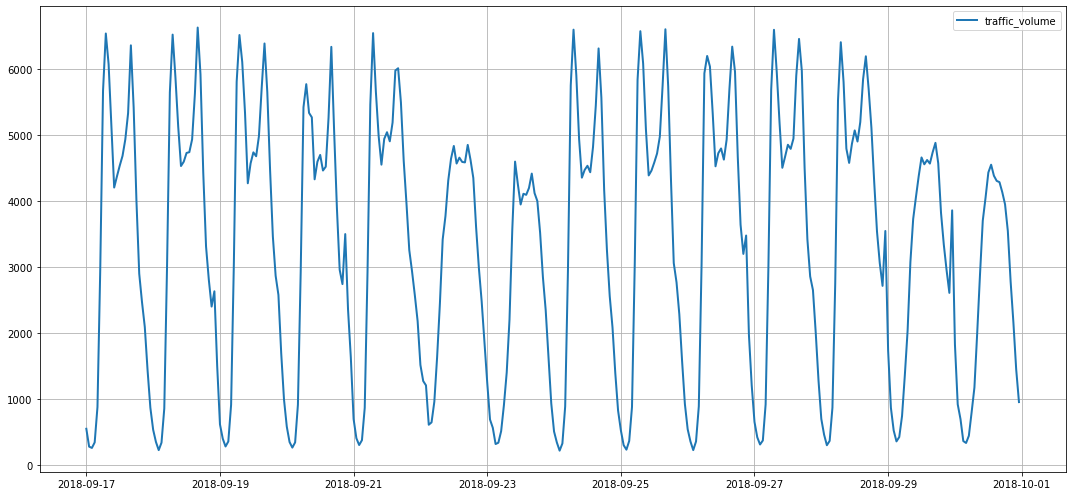

In [37]:
plt.figure(figsize=(15, 7))
plt.plot(test_df.index, test_df[['traffic_volume']].values, label='traffic_volume', linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)

## Построение baseline прогноза

Для построения baseline прогноза рассчитаем на обучающей выборке средние значения по загрузке метро по дням и часам. И применим данный прогноз на тестовую выборку.
Создадим ключ "день недели - час" для подцепки данных в обеих выборках.

In [38]:
train_df['weekday_hour'] = train_df['weekday'].astype(str) + ' - ' + train_df['hour'].astype(str)
test_df['weekday_hour'] = test_df['weekday'].astype(str) + ' - ' + test_df['hour'].astype(str)

In [39]:
train_wh = pd.pivot_table(train_df, index=['weekday_hour'], values='traffic_volume', aggfunc=np.mean).reset_index()
train_wh = train_wh.rename({'traffic_volume' : 'traffic_prediction'}, axis=1)
train_wh.head()

,weekday_hour,traffic_prediction
0,Friday - 0,721.818182
1,Friday - 1,445.363636
2,Friday - 10,4554.818182
3,Friday - 11,4797.545455
4,Friday - 12,5083.727273


Подсоединим прогноз к тестовой выборке.

In [40]:
test_df = test_df.reset_index()
test_df = test_df.merge(train_wh, how='left', on='weekday_hour')
test_df = test_df.set_index('date_time')
test_df.head()

,temp,traffic_volume,holiday,week,weekday,hour,month,year,weekday_hour,traffic_prediction
date_time,,,,,,,,,,
2018-09-17 00:00:00,296.58,550.0,0.0,38,Monday,0,9,2018,Monday - 0,748.363636
2018-09-17 01:00:00,296.19,280.0,0.0,38,Monday,1,9,2018,Monday - 1,441.090909
2018-09-17 02:00:00,295.82,260.0,0.0,38,Monday,2,9,2018,Monday - 2,340.000000
2018-09-17 03:00:00,295.83,344.0,0.0,38,Monday,3,9,2018,Monday - 3,353.727273
2018-09-17 04:00:00,295.68,880.0,0.0,38,Monday,4,9,2018,Monday - 4,861.818182


Теперь проверим насколько хорошо полученный прогноз отражает фактический тренд.

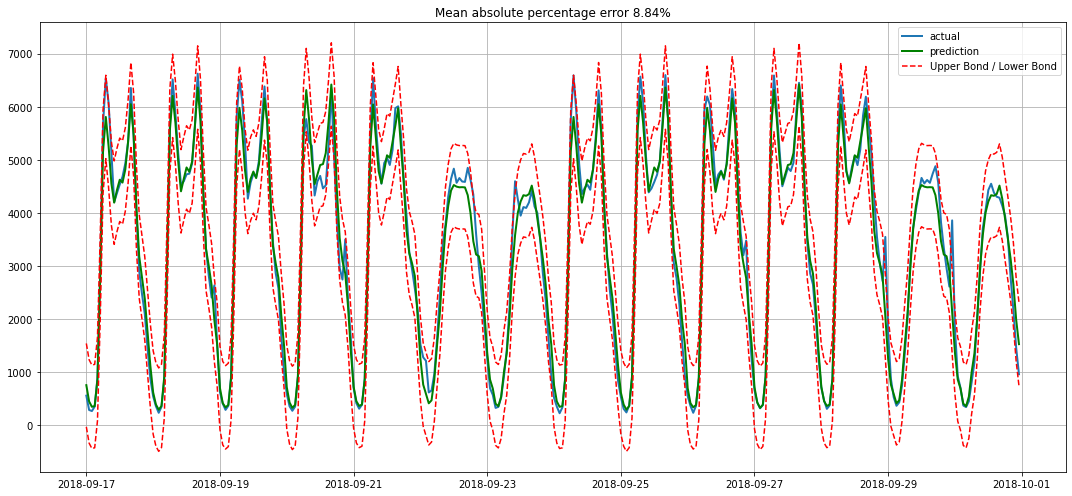

In [41]:
plt.figure(figsize=(15, 7))
plt.plot(test_df.index, test_df[['traffic_volume']].values, label="actual", linewidth=2.0)
plt.plot(test_df.index, test_df[['traffic_prediction']].values, "g", label="prediction", linewidth=2.0)

mae = mean_absolute_error(test_df['traffic_volume'], test_df['traffic_prediction'])
deviation = np.std(test_df['traffic_volume'] - test_df['traffic_prediction'])
lower_bond = test_df['traffic_prediction'] - (mae + 1.96 * deviation)
upper_bond = test_df['traffic_prediction'] + (mae + 1.96 * deviation)
plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
plt.plot(lower_bond, "r--")
error = mean_absolute_percentage_error(test_df['traffic_prediction'], test_df['traffic_volume'])
plt.title("Mean absolute percentage error {0:.2f}%".format(error))
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)

Из графика выше видно, что модель в целом неплохо повторяет тренд исходных данных. Средняя относительная ошибка равна 8,84%.

## Построение модели SARIMA
Теперь построим модель SARIMA на обучающей выборке и сделаем прогноз на тестовой. Запишем функцию для построения графиков.

In [64]:
def plotSARIMA(series, model, col, s=24 * 7, d=1, plot_intervals=True):
    """
    Plots model vs predicted values
    :param series:   Dataset with timeseries
    :type series:     pd.DataFrame
    :param model:    Fitted SARIMA model
    :type model:      sm.tsa.statespace.SARIMAX
    """
    # adding model values
    data = series.copy()
    data.columns = [col]
    data['arima_model'] = model.forecast(steps=len(data), exog=data[col])
    
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data[col], data['arima_model'])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(data['arima_model'], color='g', label="model")
    plt.plot(data[col], label="actual")
    
    if plot_intervals:
        mae = mean_absolute_error(data[col], data['arima_model'])
        deviation = np.std(data[col] - data['arima_model'])
        lower_bond = data['arima_model'] - (mae + 1.96 * deviation)
        upper_bond = data['arima_model'] + (mae + 1.96 * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
    
    plt.legend()
    plt.grid(True)

Построим модель

In [43]:
%%time

p, d, q = 1, 1, 1
P, D, Q = 0, 1, 0
s = 24 * 7

model = sm.tsa.statespace.SARIMAX(train_df['traffic_volume'],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s)).fit(disp=-1)

Wall time: 4min 6s


Теперь проверим насколько хорошо модель предсказывает данные на тестовой выборке.

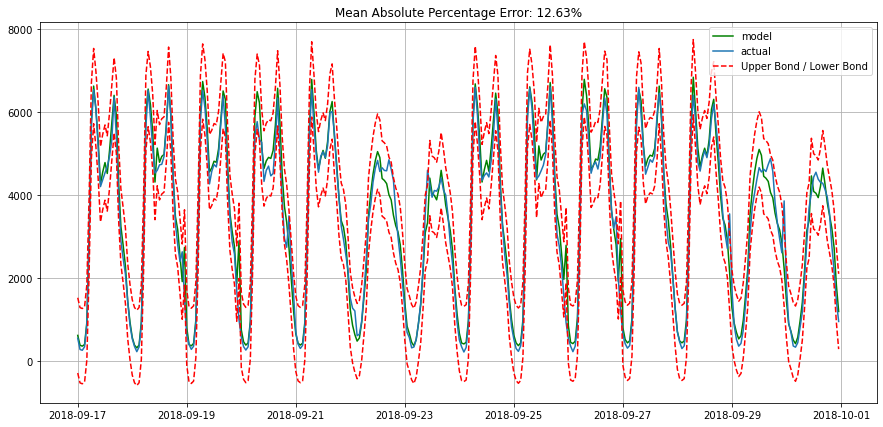

In [65]:
plotSARIMA(test_df[['traffic_volume']], model, col='traffic_volume', s=s, d=d, plot_intervals=True)

Из графика мы видим, что модель SARIMA также неплохо повторяет тренд тестовой выборки. Однако, если сравнивать два прогноза, то по графикам видно, что SARIMA менее улавливает определенные всплески, чем baseline прогноз. Вследствие у этой модели ошибка выше - 12,63%.

## Построение прогноза с использованием методов ML
Теперь построим прогноз с помощью методов машинного обучения. Будем использовать градиентный бустинг.
Для начала запишем:
- функцию для построения переменных исходя из даты и времени.
- класса MeanEncoder для расчета средних значений по категориям.
- класса LagEncoder для расчета лагов.

In [73]:
def create_time_features(data):
    data["hour"] = data.index.hour.values
    data['hour_cos'] = np.cos(2 * np.pi * data["hour"].values / 23)
    data['hour_sin'] = np.sin(2 * np.pi * data["hour"].values / 23)
    data["is_weekend"] = data.index.weekday.isin([5,6]).astype(int)
    return data

class MeanEncoder:
    def __init__(self, y_col, cat_feat):
        self.y_col = y_col
        self.cat_feat = cat_feat
        self.mean_codes = None
    
    def fit(self, data):
        cols = [self.y_col] + self.cat_feat
        self.mean_codes = data[cols].groupby(self.cat_feat).mean().to_dict()[self.y_col]
    
    def get_period_means(self, data):
        return data[self.cat_feat].apply(self._encode_with_mean, axis=1)
    
    def _encode_with_mean(self, row):
        key = tuple(row)
        val = self.mean_codes[key]
        return val

class LagEncoder:
    def __init__(self, start_lag, end_lag):
        self.start_lag = start_lag
        self.end_lag = end_lag
        self.lag_columns = []
        for i in range(self.start_lag, self.end_lag+1):
            col_name = "lag_{}".format(i)
            self.lag_columns.append(col_name)
    
    def get_lags(self, series):
        df_lags = pd.DataFrame(index=series.index)
        for i in range(self.start_lag, self.end_lag+1):
            col_name = self.lag_columns[i-1]
            df_lags[col_name] = series.shift(i)
        return df_lags

Теперь запишем функцию, которая будет формировать данные с факторами и целевой, список переменных и стартовую позиция для лагов, чтобы не брать информацию из будущего.

In [97]:
def prepare_data_from_1D_series(series, col='traffic_volume'):
    df_series = pd.DataFrame(series)
    df_series.index = pd.to_datetime(df_series.index)

    df_lags = lag_encoder.get_lags(series)
    data = pd.concat([df_series, df_lags], axis=1)
    
    data = create_time_features(data)

    mean_encoder.fit(data)
    data["mean_code"] = mean_encoder.get_period_means(data)

    data.dropna(inplace=True)
    
    data.loc[:,:] = scaler.fit_transform(data)
    
    feat_cols = data.columns.tolist()
    feat_cols.remove(col)
    
    Y = data[col]
    X = data[feat_cols]
    
    forecast_start_X = data.loc[data.index[-1],[col] + lag_encoder.lag_columns[:-1]]
    forecast_start_X.index = lag_encoder.lag_columns
    
    return X, Y, feat_cols, forecast_start_X

Рассчитаем всё

In [98]:
mean_encoder = MeanEncoder(y_col="traffic_volume", cat_feat=["hour", "is_weekend"])

In [99]:
scaler = StandardScaler()
lag_encoder = LagEncoder(start_lag=1, end_lag=30)

In [108]:
X_train, y_train, feat_cols, forecast_start_X = prepare_data_from_1D_series(train_df.traffic_volume, col='traffic_volume')

Теперь запишем функции для построения прогноза и графиков.

In [128]:
def create_forecast_timestamp(series, forecast_horizon):
    t2 = pd.to_datetime(series.index[-1])
    t1 = pd.to_datetime(series.index[-2])
    delta = t2 - t1
    t_index = [t2 + delta]
    for _ in range(forecast_horizon-1):
        t_index.append(t_index[-1] + delta)
    return t_index


def build_forecast_df(series, feat_cols, forecast_start_X, forecast_horizon):
    t_index = create_forecast_timestamp(series, forecast_horizon=forecast_horizon)
    forecast_df = pd.DataFrame(columns=['traffic_volume']+feat_cols, index=t_index)

    forecast_df = create_time_features(forecast_df)
    forecast_df["mean_code"] = mean_encoder.get_period_means(forecast_df)
    
    forecast_df.iloc[:,:] = scaler.transform(forecast_df)

    forecast_df.loc[t_index[0], lag_encoder.lag_columns] = forecast_start_X.values
    return forecast_df

def recursive_predict(model, df_forecast):
    horizon = len(df_forecast)
    df_pred = df_forecast.copy()
    forecast = []
    lagcols = lag_encoder.lag_columns
    t = df_forecast.index
    
    feat_cols = df_forecast.columns.tolist()
    feat_cols.remove('traffic_volume')
    
    for i in range(horizon):
        timestamp = t[i]
        next_x = model.predict(df_pred.loc[[timestamp], feat_cols])[0]
        if i < horizon-1:
            next_timestamp = t[i+1]
            df_pred.loc[next_timestamp, lagcols[0]] = next_x
            df_pred.loc[next_timestamp, lagcols[1:]] = df_pred.loc[timestamp, lagcols[:-1]].values
        forecast.append(next_x)
    
    df_pred.loc[:, "traffic_volume"] = forecast
    df_pred.loc[:,:] = scaler.inverse_transform(df_pred)
    return df_pred

def get_train_forecast_errors(model, X_train, y_train):
    forecast = model.predict(X_train)
    errors = y_train - forecast
    return errors

def recursive_predict_with_noise(model, df_forecast, noise_std=None):
    horizon = len(df_forecast)
    df_pred = df_forecast.copy()
    forecast = []
    lagcols = lag_encoder.lag_columns
    t = df_forecast.index
    
    feat_cols = df_forecast.columns.tolist()
    feat_cols.remove("traffic_volume")
    
    for i in range(horizon):
        timestamp = t[i]
        features = df_pred.loc[[timestamp], feat_cols]
        next_x = model.predict(features)[0]
        if noise_std is not None:
            next_x = next_x + np.random.normal(0, noise_std)
        if i < horizon-1:
            next_timestamp = t[i+1]
            df_pred.loc[next_timestamp, lagcols[0]] = next_x
            df_pred.loc[next_timestamp, lagcols[1:]] = df_pred.loc[timestamp, lagcols[:-1]].values
        forecast.append(next_x)
    
    df_pred.loc[:, "traffic_volume"] = forecast
    df_pred.loc[:,:] = scaler.inverse_transform(df_pred)
    return df_pred

def sample_bootstrap_forecasts(model, df_forecast, n_samples=100, noise_std=None):    
    df_conf_int = pd.DataFrame(index=df_forecast.index)
    
    for s in tqdm_notebook(range(n_samples)):
        df_forecasted = recursive_predict_with_noise(model, df_forecast, noise_std=noise_std)
        df_conf_int["forecast_{}".format(s)] = df_forecasted.traffic_volume.values
    
    return df_conf_int


def plotRecursivePredictionConfInterval(y_test, y_forecast, error_std):
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(y_forecast.values, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(y_forecast.values, "g", label="prediction", linewidth=2.0)
    
    scale = 1.96
    lower = y_forecast - scale * error_std
    upper = y_forecast + scale * error_std

    plt.plot(lower.values, "r--", label="upper bond / lower bond", alpha=0.5)
    plt.plot(upper.values, "r--", alpha=0.5)
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

Построим модель градиентного бустинга и построим графики

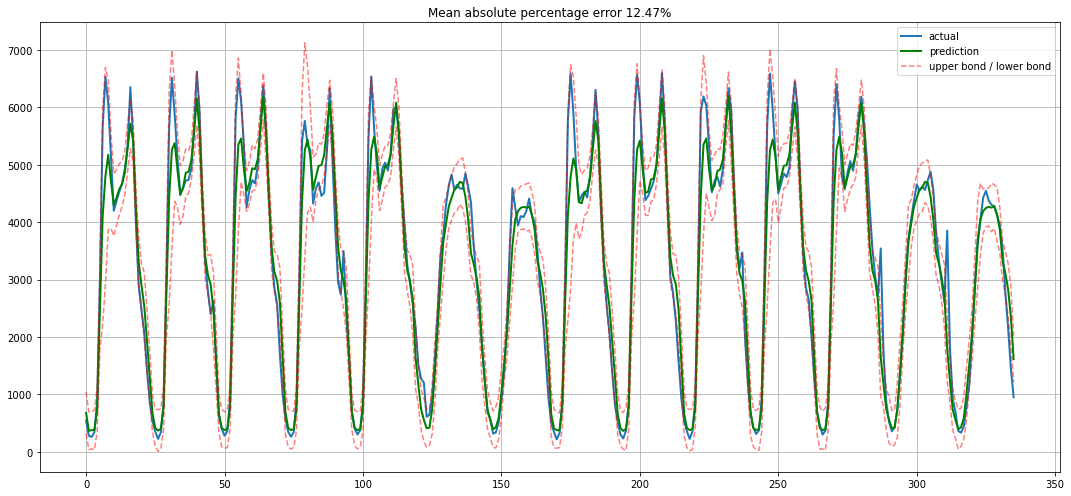

In [129]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

errors = get_train_forecast_errors(gb, X_train, y_train)
df_forc_sample = sample_bootstrap_forecasts(gb, df_forecast, n_samples=100, noise_std=errors.std())
error_std = df_forc_sample.std(axis=1)

df_forecast = build_forecast_df(train_df.traffic_volume, feat_cols, forecast_start_X, forecast_horizon=len(test_df))
df_forecasted = recursive_predict(gb, df_forecast)

plotRecursivePredictionConfInterval(test_df.traffic_volume, df_forecasted.traffic_volume, error_std)

Как мы видим, модель градиетного бустинга также повторяет тренды наших тестовых данных. Ошибка по модели получилась такая же, что и по модели SARIMA. Таким образом, обе модели не смогли обойти baseline прогноз.